# Analyze A/B Test Results 
## Introduction

In this project, I will analyze the results of an A/B test conducted by an e-commerce company using three approaches. First, I will perform hypothesis testing by manually coding the statistical calculations. Second, I will use built-in methods from the statsmodels library to conduct the same test. Lastly, I will apply a logistic regression model to evaluate the impact of the new page on conversions.

The company has developed a new web page aimed at increasing the number of users who "convert"—that is, those who choose to pay for the company's product. My objective is to evaluate whether the new page is more effective than the existing one. Specifically, I aim to determine whether the company should:
- Implement the new page,
- Retain the old page, or
- Continue the experiment to collect more data.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline
# setting seed so results can be verified
random.seed(42)

### Data Preparation and Processing
Below is the description of the data in `ab_data.csv`, there are a total of 5 columns:


|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|


In [2]:
# reading in dataset
df = pd.read_csv("ab_data.csv")
# checking the df
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# checking the number of rows and columns
df.shape

(294478, 5)

In [4]:
# number of unique users
df["user_id"].nunique()

290584

In [5]:
# proportion of users converted
df["converted"].mean()

0.11965919355605512

In [6]:
# isolating the treatment group
df_treatment = df.query('group == "treatment"')

# finding the number in the treatment group that did not see the 'new_page'
df_treatment.query('landing_page != "new_page"').count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

In [7]:
# checking for missing values
df.isnull().count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

In [8]:
# moving the accurate rows to a new df
df2 = df[
    ((df["group"] == "control") & (df["landing_page"] == "old_page"))
    | ((df["group"] == "treatment") & (df["landing_page"] == "new_page"))
]

df2.shape

(290585, 5)

In [9]:
# checking that all inaccurate rows were removed
df2[
    ((df2["group"] == "treatment") == (df2["landing_page"] == "new_page")) == False
].shape[0]

0

In [10]:
# number of unique users in df2
df2["user_id"].nunique()

290584

In [11]:
# finding the repeated user_id
df2[df2["user_id"].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
# viewing rows for duplicate user_id
df2.loc[df2["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
# removing one of the rows with a duplicate user_id.
df2 = df2.drop(labels=[2893], axis=0)
# making sure row dropped
df2.loc[df2["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [14]:
# calculating the probability of an individual converting
ppopulation = df2["converted"].mean()
ppopulation

0.11959708724499628

In [15]:
# isolating the control group
df2_control = df2.query('group == "control"')

# calculating the probability that an individual in the control group would convert
control_mean = df2_control["converted"].mean()
control_mean

0.1203863045004612

In [16]:
# isolating the treatment group
df2_treatment = df2.query('group == "treatment"')

# calculating the probability that an individual in the treatment group would convert
treatment_mean = df2_treatment["converted"].mean()
treatment_mean

0.11880806551510564

In [17]:
# calculating the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_mean - control_mean
obs_diff

-0.0015782389853555567

In [18]:
# the probability that an individual reveiced the new page
(df2_treatment.shape[0]) / (df2_treatment.shape[0] + df2_control.shape[0])

0.5000619442226688

I use the conversion rate observed in the control group to calculate the probability that an individual in the treatment group would convert. My data indicate that the treatment group resulted in fewer conversions than the control group

---


## A/B Test

In this section, I will define the null and alternative hypotheses for the A/B test. Since a timestamp is associated with each event, hypothesis testing could be done continuously, but I will base my decision on the full dataset provided. Given that the old page has a slightly higher conversion rate, I will assume it is better unless the new page shows a significant improvement at a 5% Type I error rate.

### Null Hypothesis
The null hypothesis (H₀) states that the conversion rate of the old page is greater than or equal to the conversion rate of the new page (H₀: P_old ≥ P_new). The alternative hypothesis (H₁) states that the new page has a higher conversion rate than the old page (H₁: P_old < P_new).

$$H_0: P_{\text{old}} \geq P_{\text{new}}$$

$$H_1: P_{\text{old}} < P_{\text{new}}$$

## Hypothesis $H_0$ Testing 
### Manual Walkthrough
In this section, I will assume under the null hypothesis (H₀) that the conversion rates for the old and new pages are equal to the overall conversion rate in the dataset (p_new = p_old = p_population). To test this, I will simulate (bootstrap) sample datasets for both groups, compute their conversion probabilities, and calculate the difference. This process will be repeated over 10,000 iterations to generate a sampling distribution for the difference in conversion rates, allowing me to estimate the expected variation under the null hypothesis.

In [19]:
# calculating conversion rate for p_new under the null hypothesis
p_new = df2["converted"].mean()
p_new

0.11959708724499628

In [20]:
# calculating the conversion rate for p_old under the null hypothesis
p_old = df2["converted"].mean()
p_old

0.11959708724499628

In [21]:
# creating df of all users shown the new page
n_new = df2_treatment.shape[0]
n_new

145310

In [22]:
# creating df of all users shown the old page
n_old = df2_control.shape[0]
n_old

145274

In [23]:
# simulating a sample 10,000 times for the control and treatment group
old_sam = np.random.binomial(n_old, p_old, 10000) / n_old
new_sam = np.random.binomial(n_new, p_new, 10000) / n_new

# calculate the difference in conversion rates for all simulations
p_diffs = new_sam - old_sam

In [24]:
# calculating the mean for each group of simulated samples
new_page_mean = new_sam.mean()
old_page_mean = old_sam.mean()

new_page_mean, old_page_mean

(0.11958927878329088, 0.11961874595591777)

In [25]:
# finding the difference in the converted probability
prob_diff = new_page_mean - old_page_mean
prob_diff

-2.9467172626890248e-05

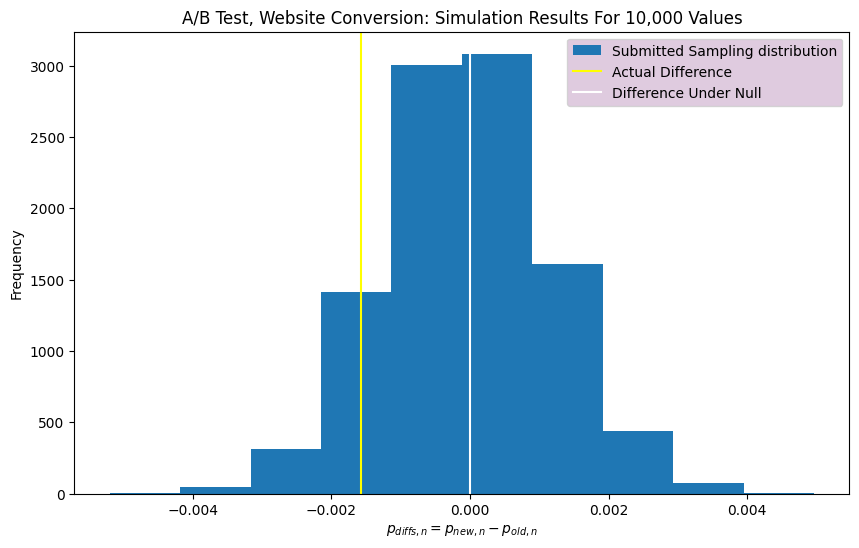

In [26]:
# plotting a histogram of the p_diffs
f, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(p_diffs, label="Submitted Sampling distribution")

# lines showing 0 and obs_diff
ax.axvline(obs_diff, color="yellow", label="Actual Difference")
ax.axvline(0, color="white", label="Difference Under Null")

# adding the labels
plt.title("A/B Test, website conversion: Simulation results for 10,000 values".title())
plt.xlabel("$p_{diffs,n} = p_{new,n} - p_{old,n}$")
plt.ylabel("Frequency")
ax.legend(facecolor="thistle")
plt.show();

In [27]:
# calculating the proportion of p_diffs that are greater than the actual difference
(p_diffs > obs_diff).mean()

0.9035

A notable portion of p_diffs surpasses the observed difference in df2. This numerical representation is known as the p-value. The p-value's magnitude is considerable, significantly greater than the chosen Type I error threshold (0.05), resulting in our inability to reject the null hypothesis. 

---


### Hypothesis Testing Using Built-In Methods
In this section, I repeated the same process using the StatsModels library in Python. This approach is more straightforward to code, while the previous section was intended for demonstration purposes.

In [28]:
# number of conversions with the old_page
convert_old = df2_control.query("converted == 1").shape[0]

# number of conversions with the new_page
convert_new = df2_treatment.query("converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = df2_control.shape[0]

# number of individuals who received new_page
n_new = df2_treatment.shape[0]

##checking the format to prevent later issues
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [29]:
# creating the arrays
count = [convert_new, convert_old]
nobs = [n_new, n_old]

# computing the test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative="larger")
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


The Z-score of -1.3109 is less than the critical value of 1.645 (chosen for a one-tailed test), indicating that we do not have sufficient evidence to reject the null hypothesis. The p-value of 0.905 is consistent with the earlier calculated p-value (0.9035), reinforcing our inability to reject the hypothesis.

---


### A Regression Approach

In this final section, I will demonstrate how regression can be used to analyze the A/B test results. Since the outcome variable is binary—conversion or no conversion—I will use logistic regression and incorporate key variables, such as an intercept and a treatment indicator.

This method allows me to determine whether there is a statistically significant difference in conversion rates based on the page type a customer receives.

In [30]:
# creating an intercept column
df2["intercept"] = 1
# creating a dummy variable column, were a 1 = treatment
df2["ab_page"] = pd.get_dummies(df2["group"])["treatment"].astype(int)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [31]:
# creating the regression model on the two columns just created
log_model = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
# fitting the model to predict whether on individual converts
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [32]:
# getting the results summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 04 Feb 2025   Pseudo R-squ.:               8.077e-06
Time:                        20:32:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with 'ab_page' is 0.19, which differs from the value obtained previously. This variation arises because a logistic regression model performs a two-tailed test, whereas a one-tailed test was conducted in the previous section. Despite this difference, the p-value remains greater than the Type I error threshold (0.05), meaning that the null hypothesis still cannot be rejected.


#### Additional Factors Affecting Conversion Rates
Several factors can influence conversion rates. Existing customers may resist changes, while a novelty effect might initially make them more receptive.

However, adding additional terms to the regression model comes with potential drawbacks. Including highly correlated variables can introduce multicollinearity, which distorts the reliability of coefficient estimates. Additionally, adding more factors increases the risk of Simpson’s paradox, where aggregated data trends differ from subgroup trends, potentially leading to misleading conclusions.

---


#### Adding countries
In this section, I will test whether the conversion rate varies across different page types while also examining the impact of the user's country of residence.

In [33]:
# getting data from countries.csv
countries = pd.read_csv("countries.csv")
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [34]:
# join with the df2 dataframe
df_new = pd.merge(df2, countries, on="user_id", how="inner")
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [35]:
# finding the different values for the country column
df_new["country"].value_counts()

country
US    203619
UK     72466
CA     14499
Name: count, dtype: int64

In [36]:
# creating the necessary dummy variables
df_new[["CA", "UK", "US"]] = pd.get_dummies(df_new["country"]).astype(int)
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [37]:
### checking to see if country hand an impact on conversions rate
log_model = sm.Logit(df_new["converted"], df_new[["intercept", "UK", "CA", "ab_page"]])

result = log_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 04 Feb 2025   Pseudo R-squ.:               2.323e-05
Time:                        20:32:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

From this summary, it is evident that the p-values associated with the countries exceed the Type I error threshold of 0.05. As a result, I cannot reject the null hypothesis, leading to the conclusion that there is no significant difference in conversion rates based on the country of origin.

#### Page and Country Interaction
In this section, I will examine the interaction between page type and country of residence to determine if there is a significant effect on conversion rates. I will first create the necessary additional column, and then will fit the regression model to the data.

In [38]:
# creating the new columns
df_new["UK_inter"] = df_new["UK"] * df_new["ab_page"]
df_new["CA_inter"] = df_new["CA"] * df_new["ab_page"]
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,UK_inter,CA_inter
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [39]:
# fitting the model and results
lm = sm.Logit(
    df_new["converted"],
    df_new[["intercept", "UK", "CA", "ab_page", "UK_inter", "CA_inter"]],
)
result = lm.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 04 Feb 2025   Pseudo R-squ.:               3.482e-05
Time:                        20:32:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK_inter       0.0314      0.027      1.181      0.238      -0.021       0.084
CA_inter      -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

In this model, the intercept corresponds to the 'US' and the old page version. The notable p-values (all exceeding the Type I error threshold of 0.05) associated with 'UK', 'CA', 'ab_page', 'UK_inter', and 'CA_inter' indicate a consistent result—the failure to reject the null hypothesis. Both the page type and country of origin appear to have minimal impact on predicting conversion. Given this, it would not be practical to switch to the new page format.

## Results
Across all statistical tests and regression analyses, I found no compelling evidence that switching to the new page would improve conversion rates. Both the page type and the user's country of residence had no statistically significant impact on conversion likelihood. Given these findings, it would not be practical to implement the new page, as there is no indication it would lead to higher conversions. Future analyses could explore additional factors or external influences that may play a role in conversion behavior.